In [66]:
import pickle
import keras
import matplotlib.cm as cm
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from IPython.display import Image, display
import os

In [63]:
######################################################
# load my model and history
######################################################

# Cargar el modelo
model = load_model('Saved_Models/model_resize_15-15.h5')

# Cargar la lista de historias
with open('Saved_Models/histories_resize_15-15.pkl', 'rb') as file:
    history_list = pickle.load(file)

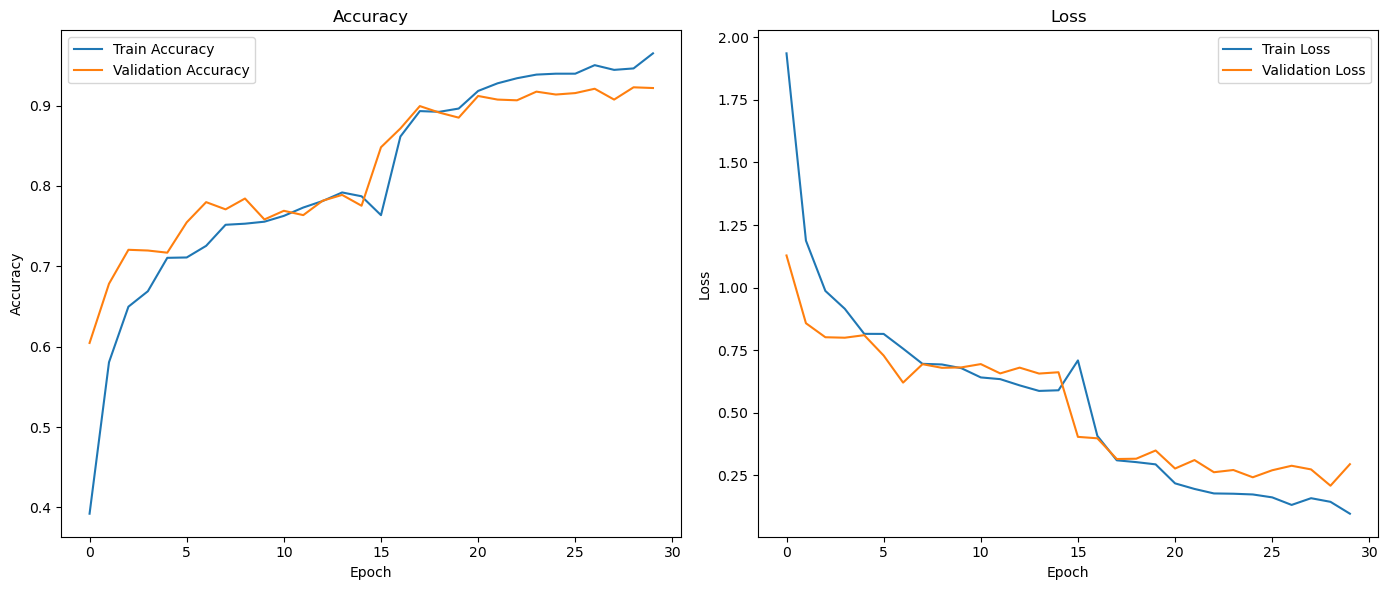

In [28]:
#######################################################################
# Display Accuracy and Loss only to make sure, I picked the right model
#######################################################################

# Crear una figura y ejes para el gráfico
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

history_acc = []
history_val_acc = []
history_loss = []
history_val_loss = []

# Recopilar las precisiones (accuracy) de todas las historias en history_list
for history in history_list:
    history_acc.extend(history['acc'])
    history_val_acc.extend(history['val_acc'])
    history_loss.extend(history['loss'])
    history_val_loss.extend(history['val_loss'])

# Graficar la precisión (accuracy) en función de las épocas
axes[0].plot(history_acc, label='Train Accuracy')
axes[0].plot(history_val_acc, label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history_loss, label='Train Loss')
axes[1].plot(history_val_loss, label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [29]:
######################################################
# Print layer names of my model
######################################################
for layer in model.layers:
    print(layer.name)
model.summary()

vgg16
global_average_pooling2d
dense
dropout
dense_1
dropout_1
dense_2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)           

In [51]:
base_model = model.get_layer('vgg16')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Loose Silky-bent
1/1 [==============================] - 0s 135ms/step


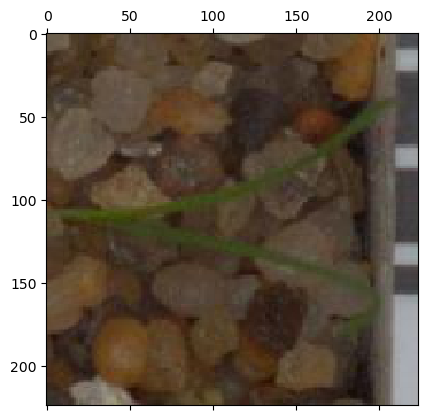

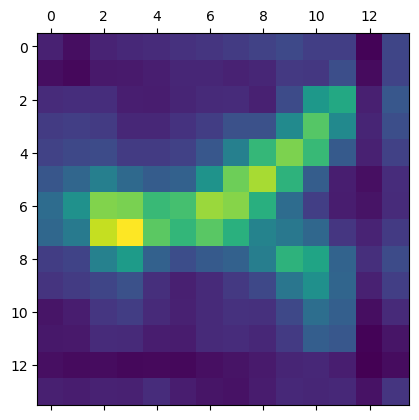

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16248\3642203299.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


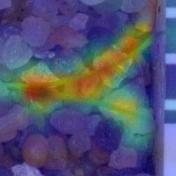

Cleavers
1/1 [==============================] - 0s 140ms/step


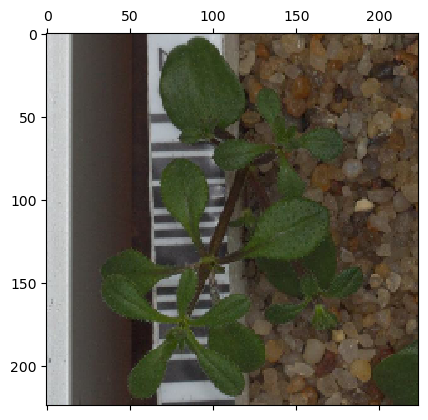

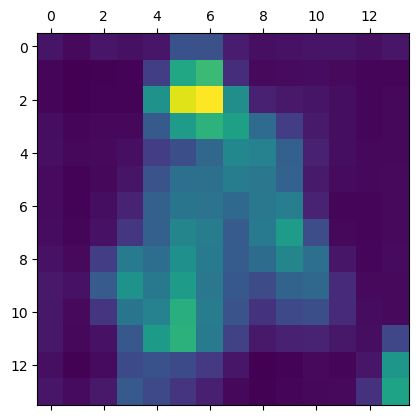

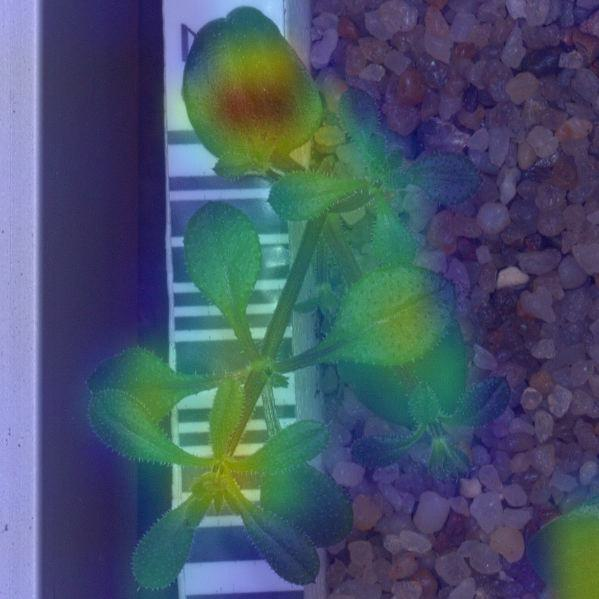

Black-grass
1/1 [==============================] - 0s 138ms/step


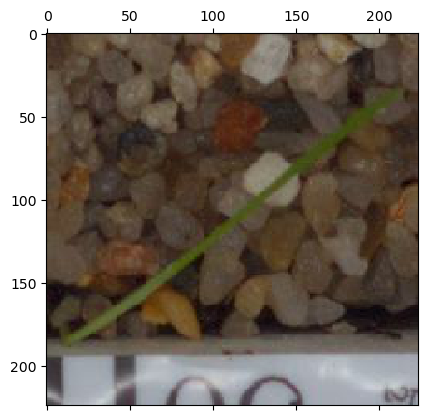

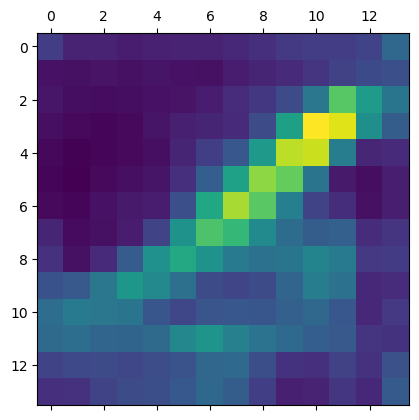

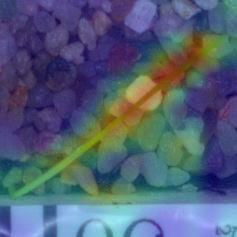

Scentless Mayweed
1/1 [==============================] - 0s 130ms/step


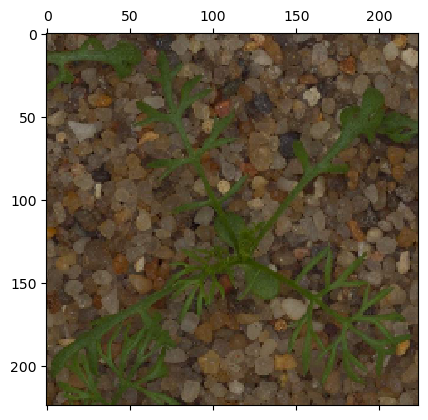

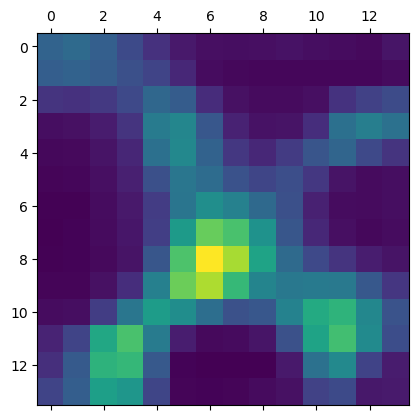

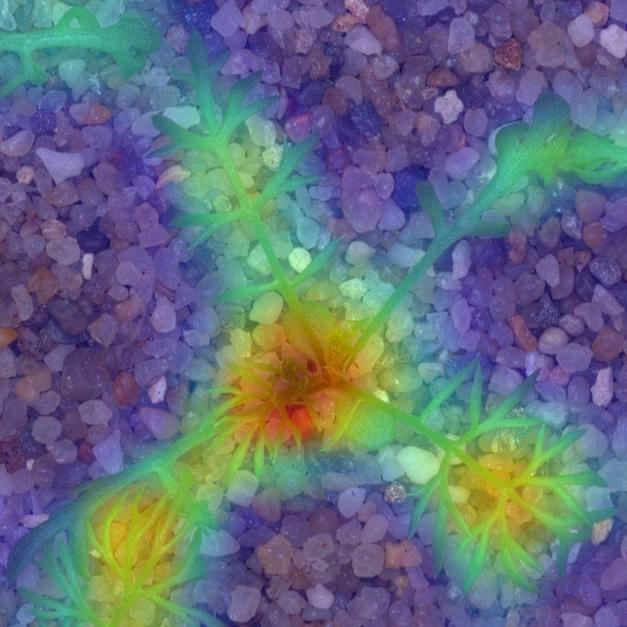

Maize
1/1 [==============================] - 0s 135ms/step


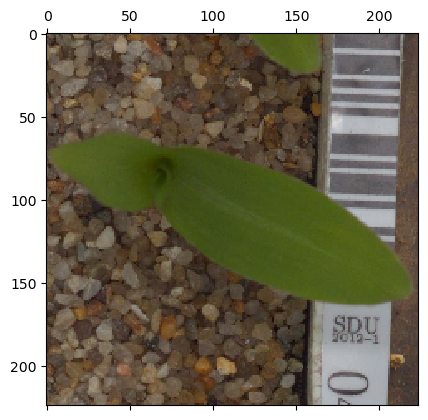

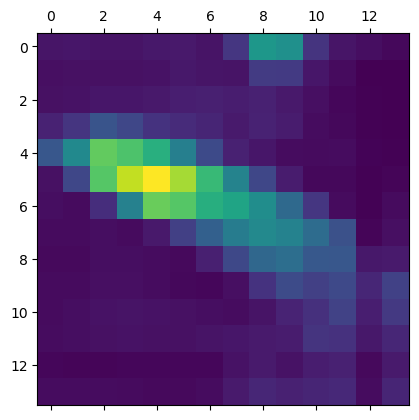

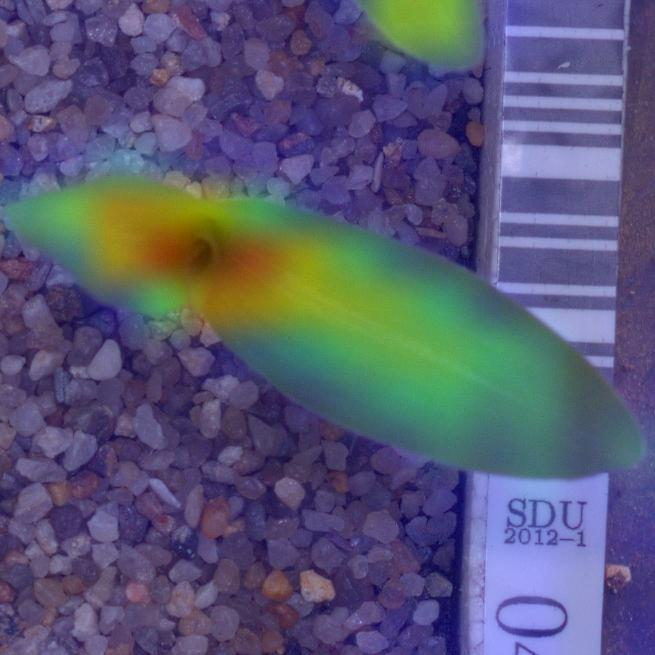

Charlock
1/1 [==============================] - 0s 136ms/step


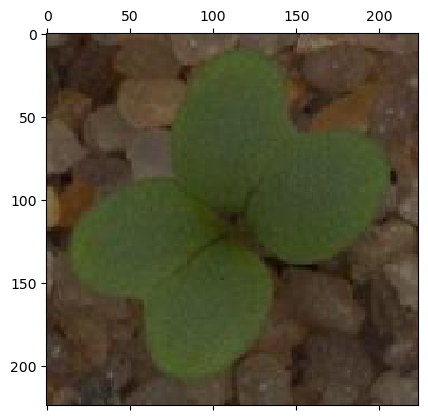

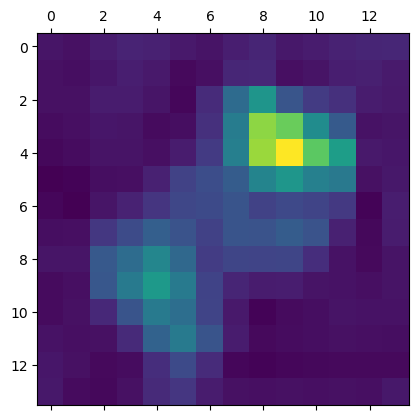

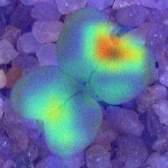

Sugar beet
1/1 [==============================] - 0s 136ms/step


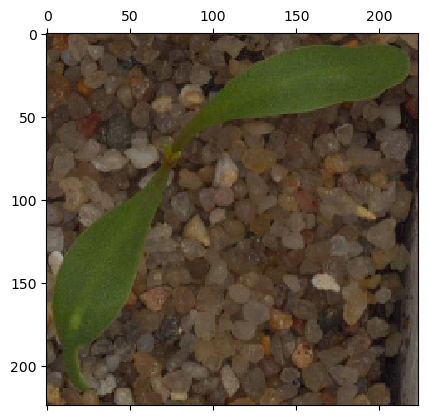

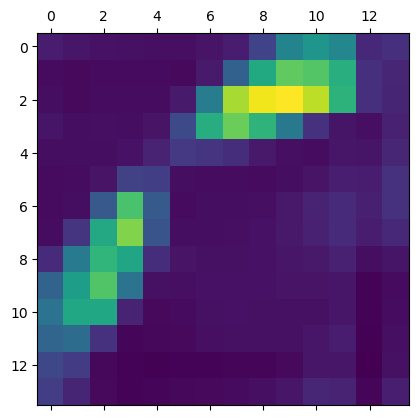

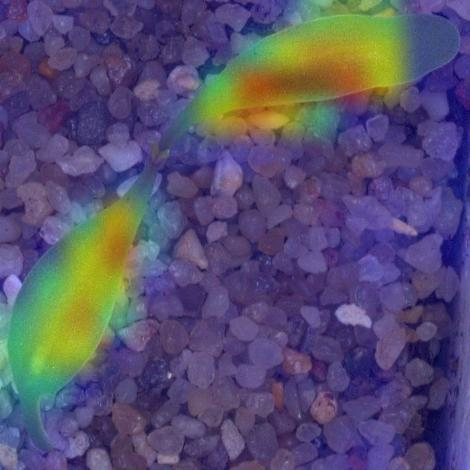

Fat Hen
1/1 [==============================] - 0s 165ms/step


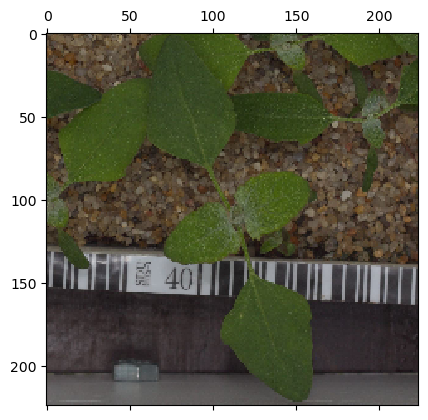

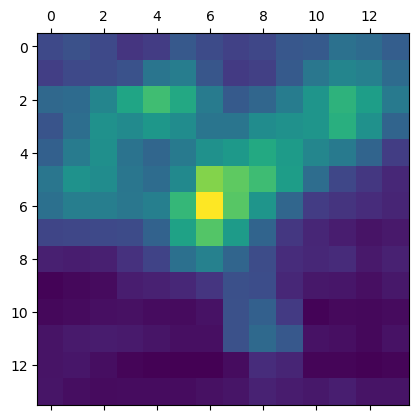

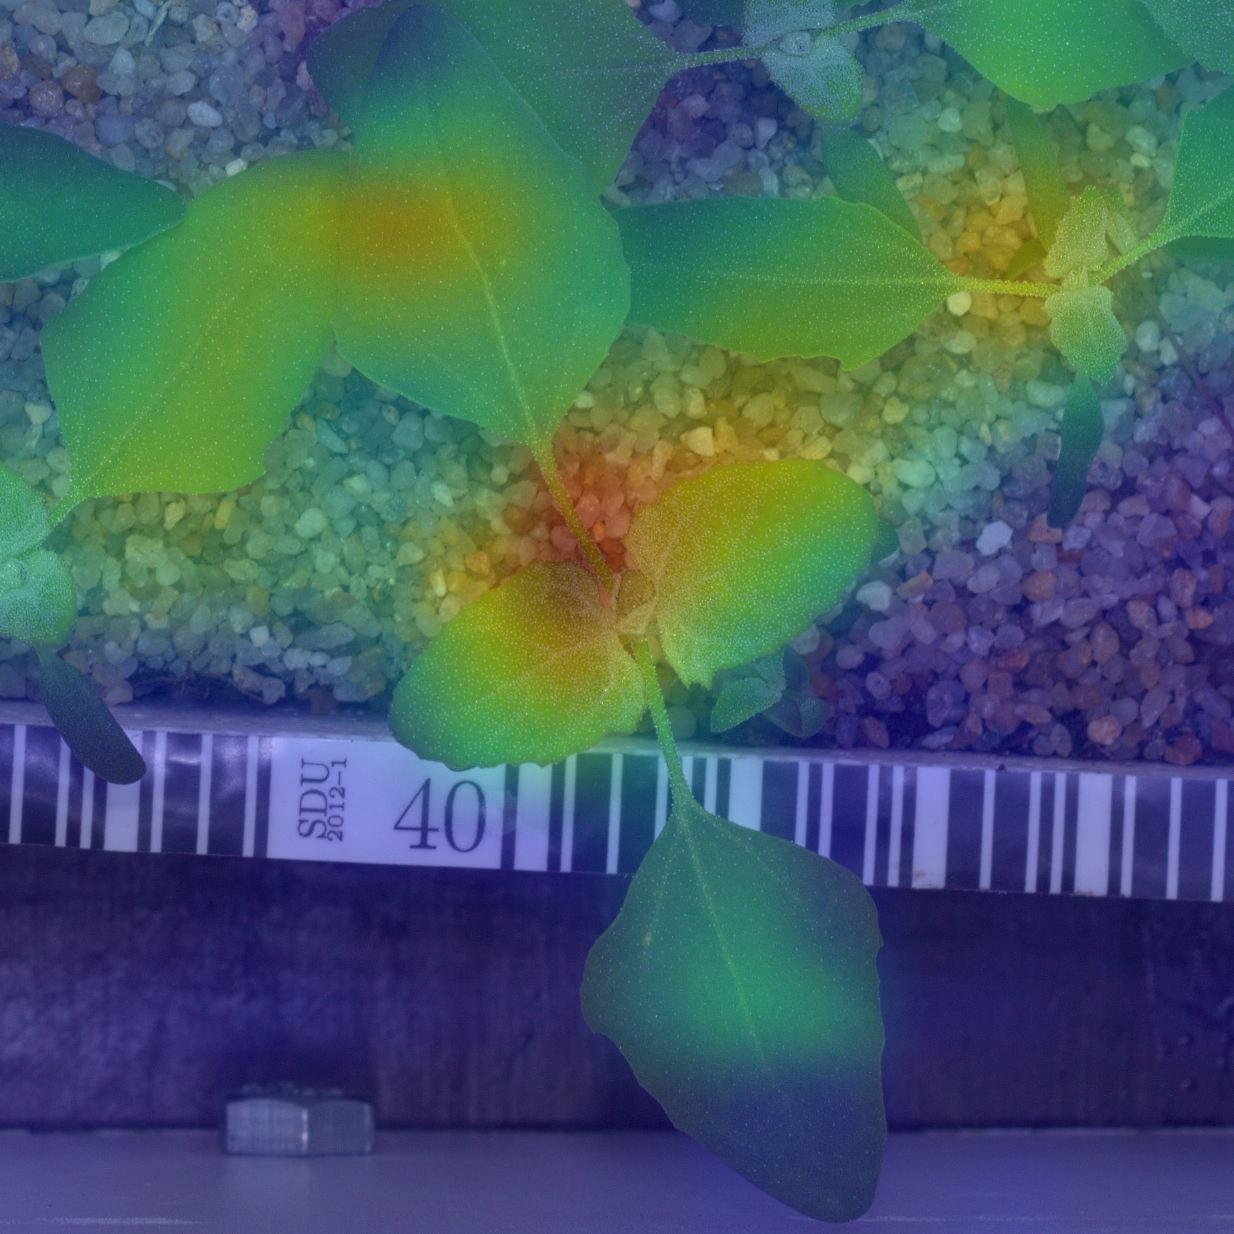

Small-flowered Cranesbill
1/1 [==============================] - 0s 120ms/step


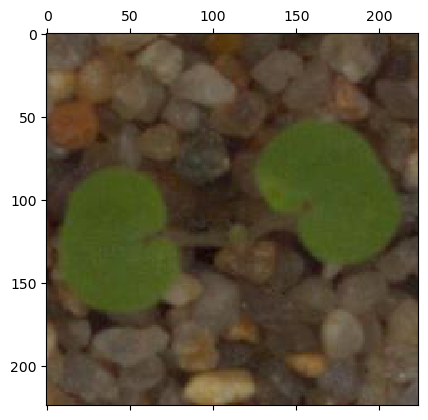

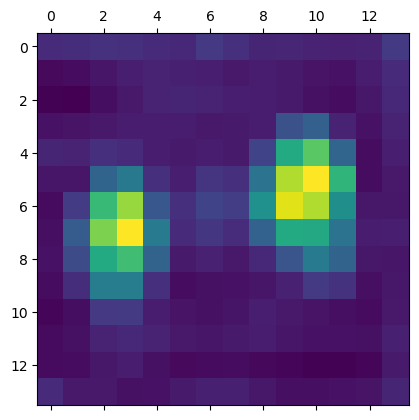

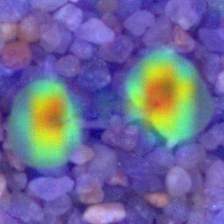

Common wheat
1/1 [==============================] - 0s 120ms/step


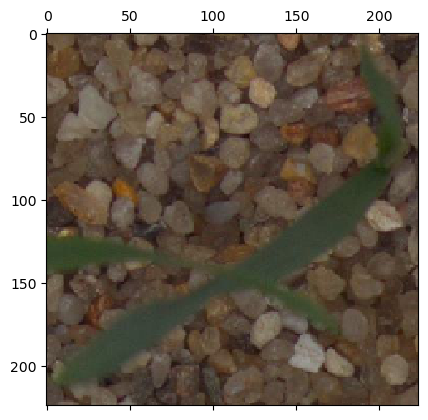

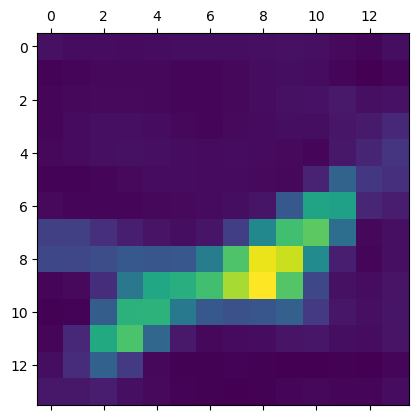

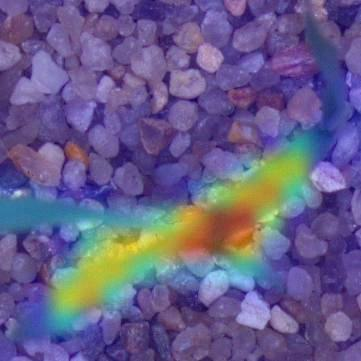

Common Chickweed
1/1 [==============================] - 0s 121ms/step


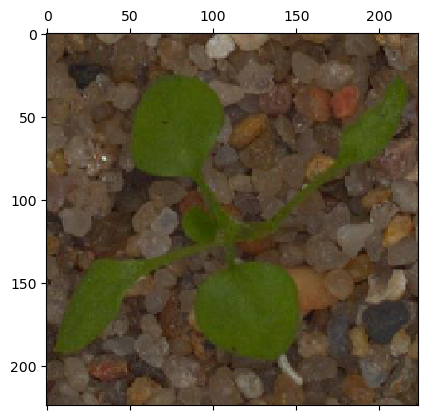

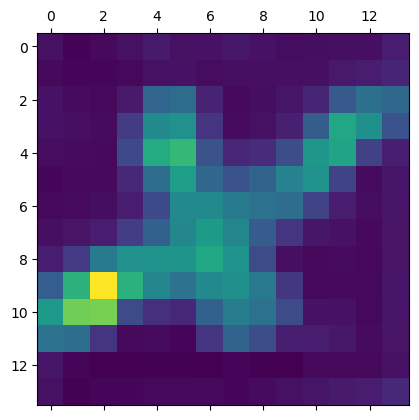

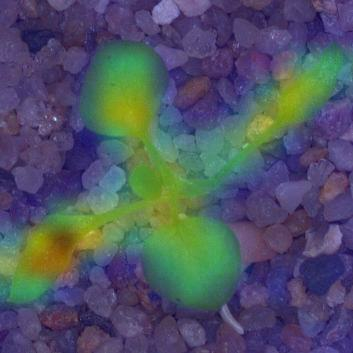

Shepherd Purse
1/1 [==============================] - 0s 140ms/step


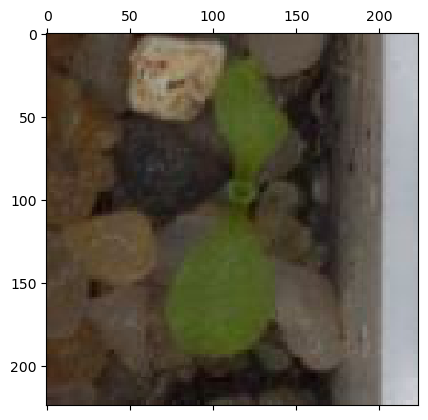

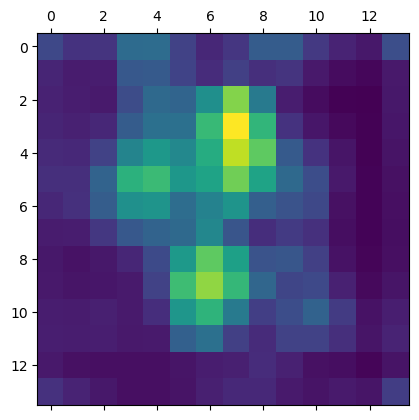

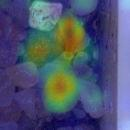

In [72]:
##############################################
# Definir una función para Grad-CAM:
##############################################

def grad_cam(model, image, class_index, layer_name):
    last_conv_layer = model.get_layer(layer_name)
    gradient_model = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

    with tf.GradientTape() as tape:
        preds, conv_output = gradient_model(image)
        #class_output = preds[:, class_index]
        class_output = preds

    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    #heatmap = tf.reduce_mean(conv_output * pooled_grads[..., tf.newaxis], axis=-1)
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    ########

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

##############################################
# Definir una función resultado superpuesto:
##############################################

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

##############################################
# Definir funcion para Preprocesar la imagen
##############################################

def preproces_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  return preprocess_input(x)

##############################################
# DOING
##############################################

plants_list = ['Loose Silky-bent', 'Cleavers', 'Black-grass', 'Scentless Mayweed', 'Maize', 'Charlock', 'Sugar beet', 'Fat Hen', 'Small-flowered Cranesbill', 'Common wheat', 'Common Chickweed', 'Shepherd Purse']

for plant in plants_list:
    print(plant)
    option = plant
    img_path = os.path.join("../Test_original", option, "image1.jpg")

    x = preproces_image(img_path)

    # Obtener la prediccion segun mi modelo
    class_index = np.argmax(model.predict(x))

    # Obtener la ultima capa convolucional de mi modelo
    base_model = model.get_layer('vgg16')
    layer_name = 'block5_conv3'
    
    # Obtener la interpretacion Grad-CAM
    heatmap = grad_cam(base_model, x, class_index, layer_name)

    # Display original image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.matshow(img)
    plt.show()

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()

    # Save and diplay superimposed heatmap
    os.makedirs(os.path.join("Saved_images", option), exist_ok=True)
    save_and_display_gradcam(img_path, heatmap, cam_path = os.path.join("Saved_images", option, "grad_cam_image1.jpg"))